<a href="https://colab.research.google.com/github/Taejin1221/Lab_Experiment/blob/main/Trajectory_Clustering/Trajectory_Clustering_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import modules

In [2]:
import os, cv2, glob
import numpy as np
import pandas as pd

'''
If you want to know this file,
refer to https://github.com/smupilab/Trajectory-AE/blob/master/utils/convertImage.py
'''
from drive.MyDrive.University.PiLab.Experiment.Codes import convertImage as utils

In [3]:
os.getcwd()

'/content'

# Set Constants

In [4]:
# Constants
WIDTH, HEIGHT = 256, 256

EXPERIMENT_DATA = {
    'name' : 'Trajectory_Clusetring',
    'number' : '7',
    'date' : '03-25-2021',
    'description' : 'Delete All Black Image\n' + 'Make test data size to 10\n' + 'Save model and test images\n'
    }

ROOT_DIR = os.path.join('/content', 'drive','MyDrive','University','PiLab','Experiment' )
DATA_DIR = os.path.join( ROOT_DIR, 'Data', 'Trajectory_virtual_data')
RESULT_DIR = os.path.join( ROOT_DIR, 'Results')

# Load and Preprocessing Data

## Convert CSV to Image

In [5]:
os.chdir( DATA_DIR )

files = glob.glob( '*csv' )

generator = utils.Map2ImageGenerator( WIDTH, HEIGHT, 0 )

images = [ ]
for file in files:
    csv_file = pd.read_csv( file, names = [ 'lat', 'long', 'num' ], header = None )

    images.append( generator.ConvertImage( csv_file ) )

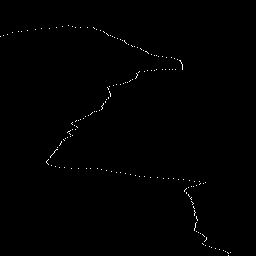

In [6]:
from google.colab.patches import cv2_imshow

cv2_imshow( images[0] )

## Crop Image

In [7]:
CROP_WIDTH, CROP_HEIGHT = 32, 32

cropped_images = [ ]
for image in images:
    for i in range( 0, HEIGHT, CROP_HEIGHT ):
        for j in range( 0, WIDTH, CROP_WIDTH ):
            curr_image = [ ]
            for ii in range( i, i + CROP_HEIGHT ):
                curr_image.append( image[ii][j : j + CROP_WIDTH] )
            cropped_images.append( curr_image )

<Figure size 432x288 with 0 Axes>

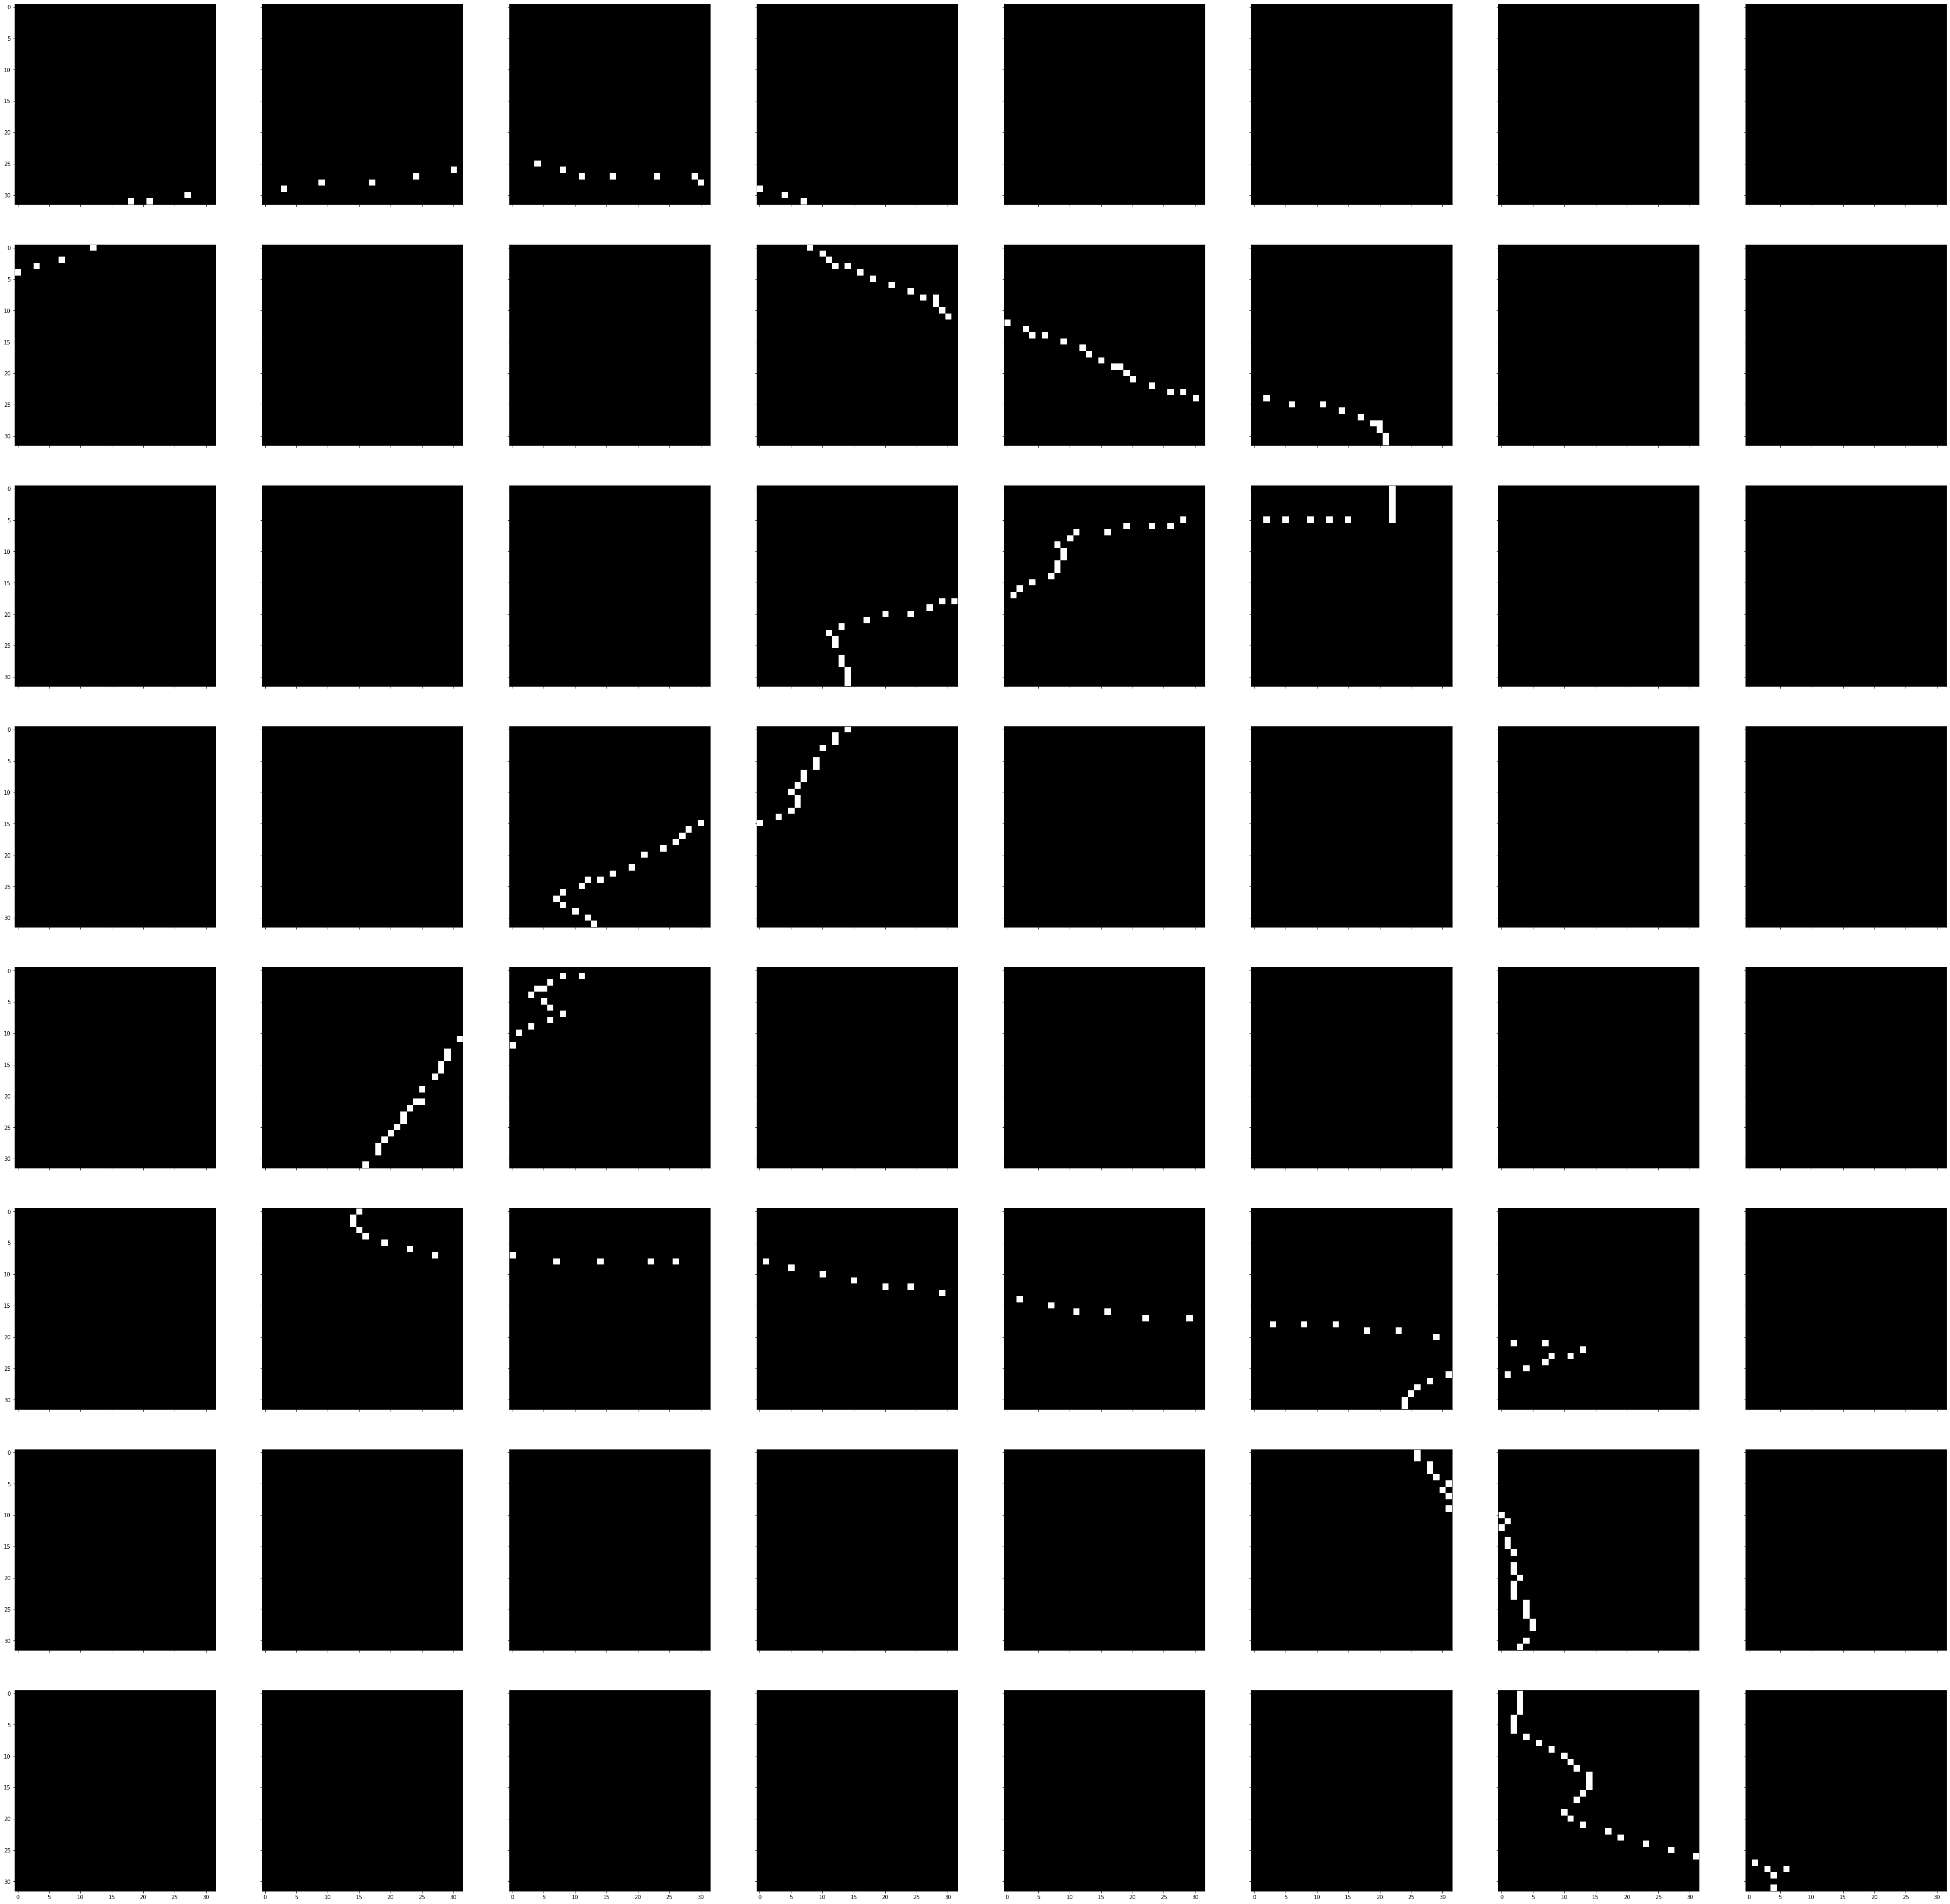

In [8]:
import matplotlib.pyplot as plt

plt.gray()

row, col = HEIGHT // CROP_HEIGHT, WIDTH // CROP_WIDTH
fig, ax = plt.subplots( row, col, True, True, figsize = ( 64, 64 ) )
for i in range( row * col ):
    ax[i // row][i % col].imshow( cropped_images[i] )
plt.show()

In [10]:
print( len(cropped_images) )

4224


## Delete All Black Image

In [12]:
X_train = [ ]
for img in cropped_images:
    not_zero = 0
    for i in range( CROP_HEIGHT ):
        for j in range( CROP_WIDTH ):
            if ( img[i][j] > 0 ):
                not_zero += 1
    
    if ( not_zero != 0 ):
        X_train.append( img )

In [13]:
X_train = np.array( X_train ).astype( 'float32' ) / 255.
X_train = np.reshape( X_train, ( -1, CROP_HEIGHT, CROP_WIDTH, 1 ) )

X_test = X_train[-10:]
X_train = X_train[:-10]

In [28]:
print( X_train.shape, X_test.shape )

(1165, 32, 32, 1) (10, 32, 32, 1)


# Construct AE Model

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [15]:
af, pd = 'relu', 'same' # activation function adn padding value

encode_input = layers.Input( ( CROP_HEIGHT, CROP_WIDTH, 1 ) )
x = layers.Conv2D( 16, ( 9, 9 ), activation = af, padding = pd )( encode_input )
x = layers.MaxPooling2D( ( 2, 2 ), padding = pd )( x )

x = layers.Conv2D( 16, ( 7, 7 ), activation = af, padding = pd )( x )
x = layers.MaxPooling2D( ( 2, 2 ), padding = pd )( x )

x = layers.Conv2D( 8, ( 5, 5 ), activation = af, padding = pd )( x )
x = layers.MaxPooling2D( ( 2, 2 ), padding = pd )( x )

x = layers.Conv2D( 8, ( 3, 3 ), activation = af, padding = pd )( x )
x = layers.MaxPooling2D( ( 2, 2 ), padding = pd )( x )

feature_map_shape = x.shape
flatten_size = feature_map_shape[1] * feature_map_shape[2] * feature_map_shape[3]

x = layers.Flatten()( x )
encode_output = layers.Dense( flatten_size , activation = af )( x )

In [16]:
encoder = keras.Model( encode_input, encode_output, name = 'Encoder' )
encoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 16)        1312      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 16)        12560     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 8)           3208      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)           0   

In [17]:
decode_input = layers.Input( ( flatten_size ) )

x = layers.Dense( flatten_size, activation = af )( decode_input )
x = layers.Reshape( feature_map_shape[1:] )( x )

x = layers.Conv2DTranspose( 8, ( 3, 3 ), activation = af, padding = pd )( x )
x = layers.UpSampling2D( ( 2, 2 ) )( x )

x = layers.Conv2DTranspose( 8, ( 5, 5 ), activation = af, padding = pd )( x )
x = layers.UpSampling2D( ( 2, 2 ) )( x )

x = layers.Conv2DTranspose( 16, ( 7, 7 ), activation = af, padding = pd )( x )
x = layers.UpSampling2D( ( 2, 2 ) )( x )

x = layers.Conv2DTranspose( 16, ( 9, 9 ), activation = af, padding = pd )( x )
x = layers.UpSampling2D( ( 2, 2 ) )( x )

decode_output = layers.Conv2DTranspose( 1, ( 9, 9 ), activation = af, padding = pd )( x )

In [18]:
decoder = keras.Model( decode_input, decode_output, name = 'Decoder' )
decoder.summary()

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
reshape (Reshape)            (None, 2, 2, 8)           0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 2, 2, 8)           584       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 8)           1608      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 8, 8)           0   

In [19]:
auto_encoder = keras.Model( encode_input, decoder( encoder( encode_input ) ), name = 'Auto_Encoder' )
auto_encoder.summary()

Model: "Auto_Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
Encoder (Functional)         (None, 32)                18720     
_________________________________________________________________
Decoder (Functional)         (None, 32, 32, 1)         31585     
Total params: 50,305
Trainable params: 50,305
Non-trainable params: 0
_________________________________________________________________


# Traing Model

In [20]:
LAMBDA1, LAMBDA2 = 0.15, 0.85

def SSIM_Loss( y_true, y_pred ):
    ssim = tf.image.ssim( y_true, y_pred, max_val = 1.0, filter_size = 11,
                          filter_sigma = 1.5, k1 = 0.01, k2 = 0.03)
    
    return 1 - tf.reduce_mean( ssim )

def Hybrid_Loss( y_true, y_pred ):
    f1 = keras.losses.MAE( y_true, y_pred )
    f2 = SSIM_Loss( y_true, y_pred )

    return LAMBDA1 * f1 + LAMBDA2 * f2

# auto_encoder.compile( 'adam', loss = Hybrid_Loss )
auto_encoder.compile( 'adam', loss = 'mse' )

In [21]:
EPOCH = 300
BATCH = 128

In [22]:
history = auto_encoder.fit( X_train, X_train, epochs = EPOCH, batch_size = BATCH )

Epoch 1/300
10/10 [==============================] - 33s 30ms/step - loss: 0.0129
Epoch 2/300
10/10 [==============================] - 0s 9ms/step - loss: 0.0126
Epoch 3/300
10/10 [==============================] - 0s 9ms/step - loss: 0.0124
Epoch 4/300
10/10 [==============================] - 0s 8ms/step - loss: 0.0122
Epoch 5/300
10/10 [==============================] - 0s 9ms/step - loss: 0.0119
Epoch 6/300
10/10 [==============================] - 0s 9ms/step - loss: 0.0120
Epoch 7/300
10/10 [==============================] - 0s 9ms/step - loss: 0.0118
Epoch 8/300
10/10 [==============================] - 0s 9ms/step - loss: 0.0122
Epoch 9/300
10/10 [==============================] - 0s 9ms/step - loss: 0.0122
Epoch 10/300
10/10 [==============================] - 0s 9ms/step - loss: 0.0121
Epoch 11/300
10/10 [==============================] - 0s 9ms/step - loss: 0.0118
Epoch 12/300
10/10 [==============================] - 0s 9ms/step - loss: 0.0115
Epoch 13/300
10/10 [===============

# Test Model

In [23]:
os.chdir( RESULT_DIR )

new_result_dir = f"{EXPERIMENT_DATA['name']}_{EXPERIMENT_DATA['number']}_{EXPERIMENT_DATA['date']}_Datas"
os.mkdir( new_result_dir )
os.chdir( new_result_dir )

with open( 'Description.txt', 'w' ) as f:
    f.write( EXPERIMENT_DATA['description'] )

In [24]:
encoder.save( 'encoder.h5' )
auto_encoder.save( 'auto_encoder.h5' )

In [25]:
for idx, img in enumerate(X_test):
    plt.imshow( img.reshape( CROP_HEIGHT, CROP_WIDTH ) )
    plt.axis( 'off' )

    plt.savefig( f'test_img{idx}.png', dpi = 100  )
    plt.clf()
    plt.close()

## Check Reconstruction

Trajectory_Clusetring_7_Reconstruction(03-25-2021).png


<Figure size 432x288 with 0 Axes>

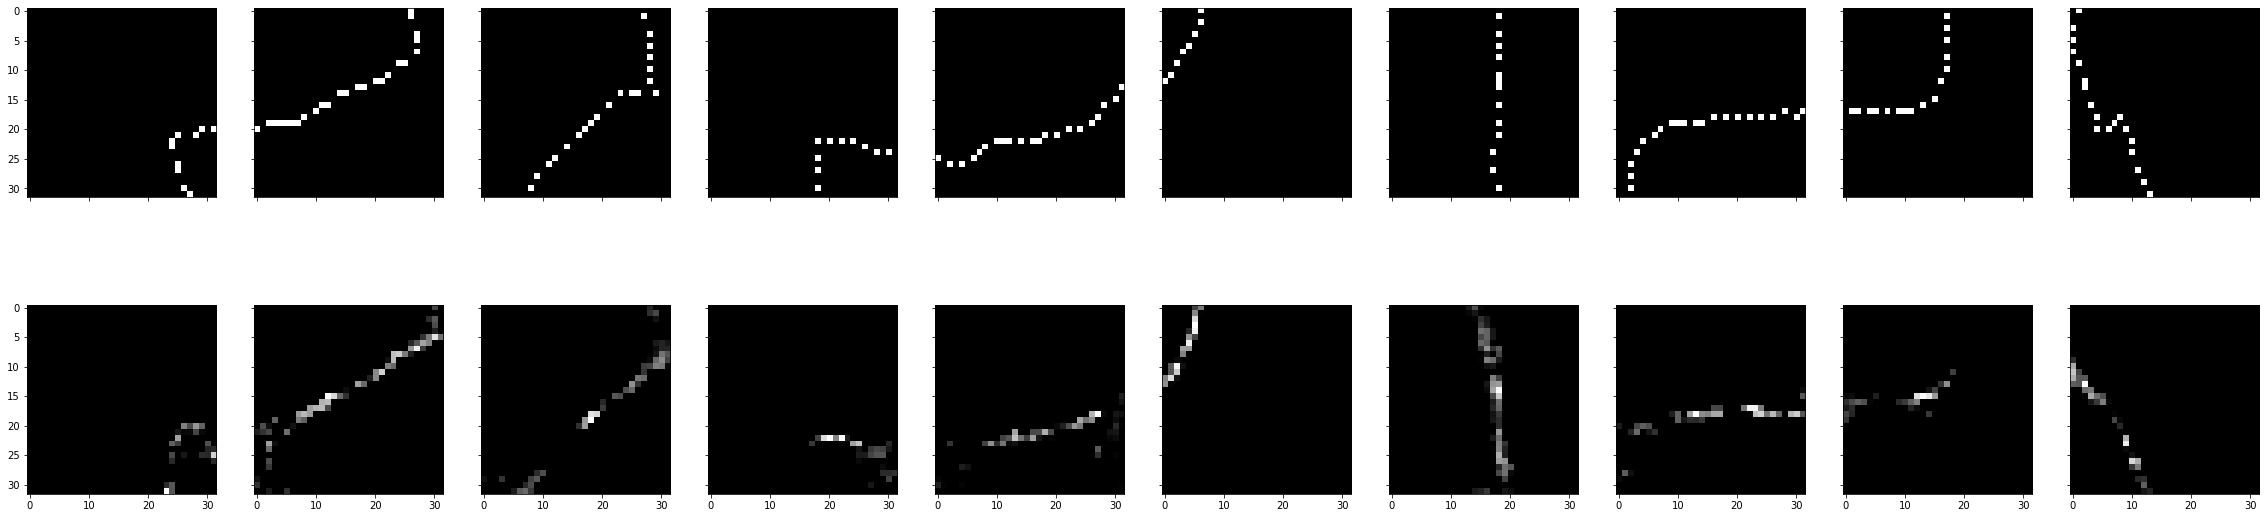

In [27]:
decoded_img = auto_encoder( X_test )

plt.gray()
n = len( X_test )
fig, ax = plt.subplots( 2, n, True, True, figsize = ( 40, 10 ) )
for i in range( n ):
    ax[0][i].imshow( X_test[i].reshape( CROP_HEIGHT, CROP_WIDTH ) )
    ax[1][i].imshow( tf.reshape( decoded_img[i], ( CROP_HEIGHT, CROP_WIDTH ) ) )

result_name = (EXPERIMENT_DATA['name'] + '_'
    + EXPERIMENT_DATA['number'] + '_'
    + 'Reconstruction' + '('
    + EXPERIMENT_DATA['date'] + ').png')
print( result_name )

plt.savefig( result_name, dpi = 300 )
plt.show()

## Clustering (HCA)

Trajectory_Clusetring_7_Clustering(03-25-2021).png


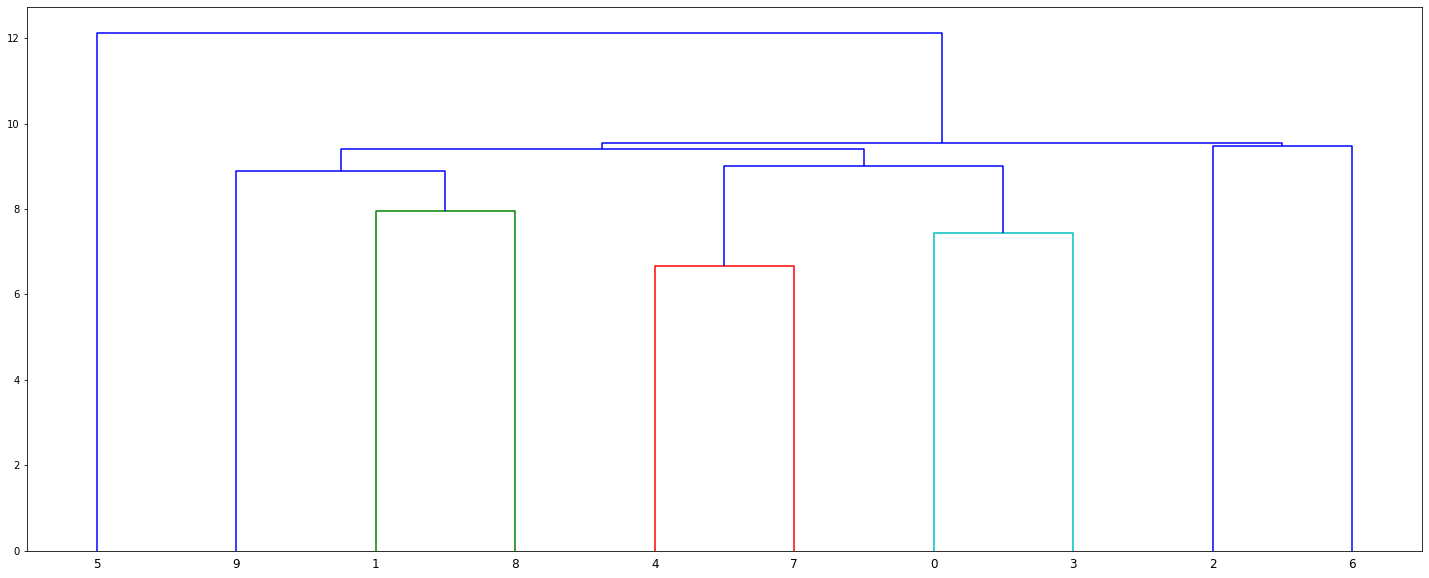

In [29]:
from scipy.cluster.hierarchy import dendrogram, linkage
low_dimension_data = encoder( X_test.reshape( ( -1, CROP_HEIGHT, CROP_WIDTH, 1 ) ) )
result = linkage( low_dimension_data )

fig = plt.figure( figsize = ( 25, 10 ) )
dn = dendrogram( result )

result_name = (EXPERIMENT_DATA['name'] + '_'
    + EXPERIMENT_DATA['number'] + '_'
    + 'Clustering' + '('
    + EXPERIMENT_DATA['date'] + ').png')
print( result_name )

plt.savefig( result_name, dpi = 300 )
plt.show()

In [32]:
for idx, dim in enumerate(low_dimension_data):
    print( f'Index: {idx}', end = ' ' )
    print( dim )

Index: 0 tf.Tensor(
[2.1413436  1.7477193  0.         0.         0.         0.
 7.2420244  1.6198639  3.5430412  2.9624507  3.415265   1.571449
 0.23413752 0.         0.         0.         0.9218748  0.
 0.         1.6533144  8.362368   0.         2.803517   0.
 0.35100523 4.4447417  0.         0.         0.         0.80874234
 0.         0.        ], shape=(32,), dtype=float32)
Index: 1 tf.Tensor(
[ 0.         0.         0.         0.         0.         0.
  9.521875   5.883141   0.         0.         6.4722223 12.181367
  4.390879   0.         0.         0.         6.1198187  4.889515
  1.7796332  0.         9.725178   0.         4.944536   0.
  4.0649333  0.         0.         0.         0.         0.
  1.085343   0.       ], shape=(32,), dtype=float32)
Index: 2 tf.Tensor(
[0.         0.         0.         0.         0.         0.
 9.345216   3.7969007  0.43130162 1.2568686  7.5392523  6.6159077
 3.2593741  0.         0.         0.         5.1757073  0.4291001
 1.7740077  1.9933949 

Trajectory_Clusetring_7_Images(03-25-2021).png


<Figure size 432x288 with 0 Axes>

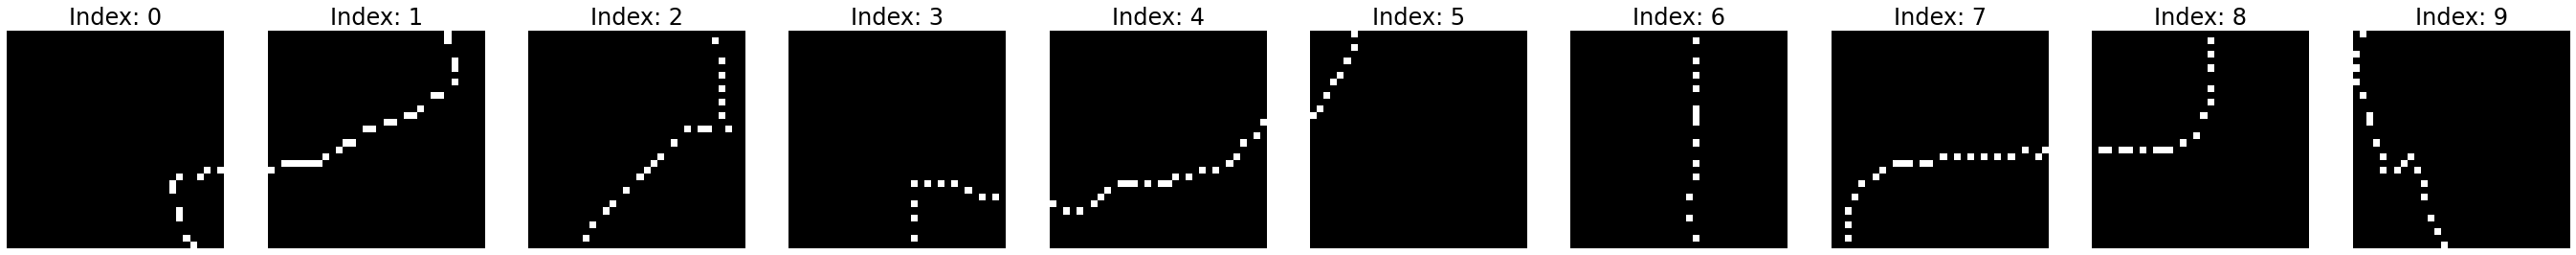

In [31]:
plt.gray()

n = 10
fig, ax = plt.subplots( 1, n, True, True, figsize = ( 48, 100 ) )
for i in range( n ):
    ax[i].imshow( X_test[i].reshape( CROP_HEIGHT, CROP_WIDTH ) )
    ax[i].set_title( f'Index: {i}', fontsize = 24 )
    ax[i].axis( 'off' )

result_name = (EXPERIMENT_DATA['name'] + '_'
    + EXPERIMENT_DATA['number'] + '_'
    + 'Images' + '('
    + EXPERIMENT_DATA['date'] + ').png')
print( result_name )

plt.savefig( result_name, dpi = 300 )
plt.show()